In [1]:
"""
This script is used for training a deep neural network (DNN) for gearbox fault diagnosis using TensorFlow and Keras.
It imports necessary libraries and modules for data processing, model building, training, and evaluation.
"""
import os

import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow_model_optimization as tfmot

import load_data
import feature_process

# Load the GearBox data

In [2]:
PTH1 = "data/BrokenTooth"
PTH2 = "data/Healthy"

WIN_LEN = 300  # How many WIN_LEN as 1 feature point
INFERENCE_DATA_POINT = 5  # This value should be considered the MCU rom size. 5*300*10*2 = 30000 float points

broken_df_train, broken_df_test = load_data.create_test_train_df_from_raw(PTH1, 1, INFERENCE_DATA_POINT, WIN_LEN, (load_data.addcol_load, load_data.addcol_fault))
healthy_df_train, healthy_df_test = load_data.create_test_train_df_from_raw(PTH2, 0, INFERENCE_DATA_POINT, WIN_LEN, (load_data.addcol_load, load_data.addcol_fault))

In [3]:
broken_df_test
# broken_df_train

,a1,a2,a3,a4,load,fault
0,2.350390,1.454870,-1.667080,-2.055610,0.0,1.0
1,2.452970,1.400100,-2.825100,0.984487,0.0,1.0
2,-0.241284,-0.267390,0.793540,0.605862,0.0,1.0
3,1.130270,-0.890918,0.696969,0.613068,0.0,1.0
4,-1.296140,0.980479,-1.130560,-0.346971,0.0,1.0
...,...,...,...,...,...,...
14995,-3.443520,-0.361539,-0.376093,-2.447550,90.0,1.0
14996,2.458310,-2.838840,0.191190,-0.201169,90.0,1.0
14997,-0.755909,3.982960,-2.321580,0.749357,90.0,1.0
14998,1.299520,4.402300,-2.232460,0.535038,90.0,1.0


# Feature Process

In [4]:
# Calculate the windows size features, combine 300 data as 1 points.
Data_healthy, Lable_healthy = feature_process.window_feature_autoencoder(healthy_df_train, 0, WIN_LEN, 4, 16)
# 200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken, Lable_broken = feature_process.window_feature_autoencoder(broken_df_train, 1, WIN_LEN, 4, 16)
print(type(Data_healthy), type(Lable_healthy))
print(f"feature array shape of healthy point: {Data_healthy.shape}, {Lable_healthy.shape}")
print(f"feature array shape of broken point: {Data_broken.shape}, {Lable_broken.shape}")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
feature array shape of healthy point: (3336, 16), (3336,)
feature array shape of broken point: (3301, 16), (3301,)


In [5]:
# Create the random 80% train and 20% test
train_data, test_data, train_labels, test_labels = feature_process.concatenate_data(Data_healthy, Data_broken, Lable_healthy, Lable_broken, 0.1, 21)
print(f"train data shape: {train_data.shape}, {train_labels.shape}")
print(f"test data shape: {test_data.shape}, {test_labels.shape}")
# save the max&min val
max_val = tf.reduce_max(train_data)
min_val = tf.reduce_min(train_data)

train data shape: (5973, 16), (5973,)
test data shape: (664, 16), (664,)


# DNN

## DNN training

In [26]:
early_stop = EarlyStopping(monitor="loss", patience=2)
model = Sequential()

model.add(Dense(4, input_shape=(16,), kernel_initializer="random_uniform"))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(8, kernel_initializer="random_uniform"))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(16, kernel_initializer="random_uniform"))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(8, kernel_initializer="random_uniform"))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(Dense(2, activation="softmax", kernel_initializer="random_uniform"))
model_settings = {}

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 4)                 68        
                                                                 
 activation_8 (Activation)   (None, 4)                 0         
                                                                 
 dense_11 (Dense)            (None, 8)                 40        
                                                                 
 activation_9 (Activation)   (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 16)                144       
                                                                 
 activation_10 (Activation)  (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 8)                

In [27]:
hist = model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
150/150 [==============================] - 1s 2ms/step - loss: 0.6926 - accuracy: 0.7497 - val_loss: 0.6910 - val_accuracy: 0.6418
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.6767 - accuracy: 0.7373 - val_loss: 0.6457 - val_accuracy: 0.7464
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.5483 - accuracy: 0.8497 - val_loss: 0.4313 - val_accuracy: 0.9046
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.3068 - accuracy: 0.9498 - val_loss: 0.2120 - val_accuracy: 0.9623
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.9653 - val_loss: 0.1228 - val_accuracy: 0.9732
Epoch 6/100
150/150 [==============================] - 0s 2ms/step - loss: 0.1176 - accuracy: 0.9661 - val_loss: 0.1035 - val_accuracy: 0.9665
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 0.1010 - accuracy: 0.9671 - val_loss: 0.0808 - val_accuracy: 0.9808

## Test Result

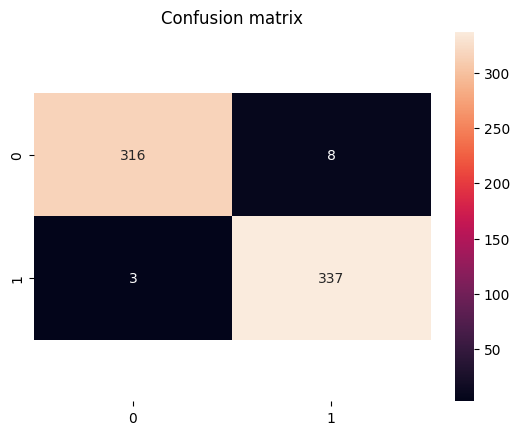

ROOT MEAN SQUARE ERROR = 0.12871000373025
Accuracy = 0.983433734939759
Precision = 0.9768115942028985
Recall = 0.9911764705882353


In [28]:
Dnn_model = model  # pass the model in order to be used latter


def cf_matrix_show(model_eval, test_data_eval, test_labels_eval):
    """
    Displays a confusion matrix heatmap and calculates evaluation metrics for a given model.
    Parameters:
    model_eval (keras.Model): The trained model to evaluate.
    test_data_eval (numpy.ndarray): The data to test the model on.
    test_labels_eval (numpy.ndarray): The true labels for the test data.
    """
    prediction_result = model_eval.predict(test_data_eval, verbose=0)
    y_pred = np.argmax(prediction_result, axis=-1)

    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(test_labels_eval, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
    # The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion matrix")
    plt.show()
    pred = y_pred.astype(int)

    # Calculating root mean square error
    rmse = np.sqrt(np.mean(((pred - test_labels_eval) ** 2)))
    print(f"ROOT MEAN SQUARE ERROR = {rmse}")
    print(f"Accuracy = {accuracy_score(test_labels_eval, pred)}")
    print(f"Precision = {precision_score(test_labels_eval, pred)}")
    print(f"Recall = {recall_score(test_labels_eval, pred)}")


cf_matrix_show(Dnn_model, test_data, test_labels)

# QAT for keeping accuracy
- Here we use QAT to prevent accuracy drop when do quantization.

In [29]:
quant_aware_model = tfmot.quantization.keras.quantize_model(Dnn_model)
optimizer = Adam(learning_rate=0.0001)
quant_aware_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (QuantizeL  (None, 16)               3         
 ayer)                                                           
                                                                 
 quant_dense_10 (QuantizeWra  (None, 4)                69        
 pperV2)                                                         
                                                                 
 quant_activation_8 (Quantiz  (None, 4)                3         
 eWrapperV2)                                                     
                                                                 
 quant_dense_11 (QuantizeWra  (None, 8)                41        
 pperV2)                                                         
                                                                 
 quant_activation_9 (Quantiz  (None, 8)               

In [30]:
hist = quant_aware_model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
150/150 [==============================] - 1s 3ms/step - loss: 0.4029 - accuracy: 0.8284 - val_loss: 0.1355 - val_accuracy: 0.9808
Epoch 2/10
150/150 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9699 - val_loss: 0.0903 - val_accuracy: 0.9774
Epoch 3/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0949 - accuracy: 0.9694 - val_loss: 0.0706 - val_accuracy: 0.9791
Epoch 4/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0809 - accuracy: 0.9707 - val_loss: 0.0662 - val_accuracy: 0.9791
Epoch 5/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.9705 - val_loss: 0.0615 - val_accuracy: 0.9782
Epoch 6/10
150/150 [==============================] - 0s 1ms/step - loss: 0.0786 - accuracy: 0.9697 - val_loss: 0.0602 - val_accuracy: 0.9774
Epoch 7/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9707 - val_loss: 0.0606 - val_accuracy: 0.9816
Epoch 

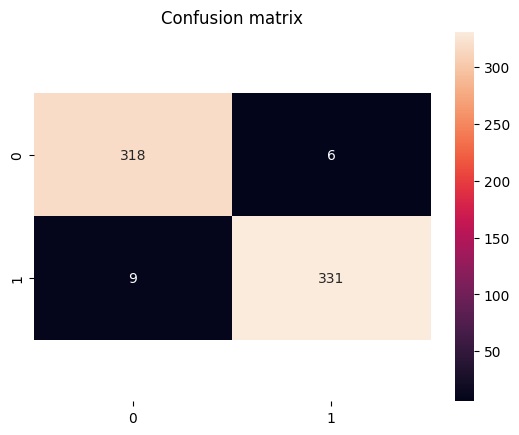

ROOT MEAN SQUARE ERROR = 0.15030090301053795
Accuracy = 0.9774096385542169
Precision = 0.9821958456973294
Recall = 0.9735294117647059


In [31]:
cf_matrix_show(quant_aware_model, test_data, test_labels)

# TensorFlow Lite Conversion

### 1. Save as saved_model

In [32]:
# If we're happy with the performance, save the model
ori_model = quant_aware_model
KERAS_MODEL_NAME = "dnn"

tf.saved_model.save(ori_model, KERAS_MODEL_NAME)

INFO:tensorflow:Assets written to: dnn\assets


INFO:tensorflow:Assets written to: dnn\assets


### 2. Save as TFLite

In [33]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
tflite_model = converter.convert()

open(os.path.join(KERAS_MODEL_NAME, (KERAS_MODEL_NAME + ".tflite")), "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\cychen38\AppData\Local\Temp\tmpfo1ax602\assets


INFO:tensorflow:Assets written to: C:\Users\cychen38\AppData\Local\Temp\tmpfo1ax602\assets


11544

### 3. Convert TFLite to C++ file

In [34]:
def tflite_to_tflu(*, models_path, c_model_name, keras_model_name, threshold, maxv, minv):
    """
    Converts a TensorFlow Lite model to a TensorFlow Lite Micro model and saves it as a C source file.
    Returns:
        None
    """

    tflite_name = os.path.join(keras_model_name, (keras_model_name + ".tflite"))
    my_f_name = os.path.join(models_path, c_model_name) + ".cc"
    ! python tflite_to_tflu_para.py --tflite_path $tflite_name --output_path $my_f_name --window_size_sample $WIN_LEN --max_val_train $maxv --min_val_train $minv --threshold_val $threshold


MODEL_PATH = "model"
C_MODEL_NAME = r"Gearbox_fault_" + KERAS_MODEL_NAME
tflite_to_tflu(models_path=MODEL_PATH, c_model_name=C_MODEL_NAME, keras_model_name=KERAS_MODEL_NAME, threshold=0, maxv=max_val.numpy(), minv=min_val.numpy())

# Convert to int8 TFLite and testing
- Int8 full quantization 

### 1. Save as Int8 TFLite

In [35]:
# Convert the model to the TensorFlow Lite format with quantization
NUM_REP_DATA_SAMPLES = 300


def _rep_dataset():
    """Generator function to produce representative dataset."""
    for idx, train_data_ele in enumerate(train_data):
        if idx >= NUM_REP_DATA_SAMPLES:
            break
        yield [tf.dtypes.cast(train_data_ele, tf.float32)]


converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
converter.representative_dataset = _rep_dataset
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()

open(os.path.join(KERAS_MODEL_NAME, (KERAS_MODEL_NAME + "_int8quantized.tflite")), "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\cychen38\AppData\Local\Temp\tmp1qk3_0xd\assets


INFO:tensorflow:Assets written to: C:\Users\cychen38\AppData\Local\Temp\tmp1qk3_0xd\assets
c:\ProgramData\miniforge3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


4352

### 2. Test the Int8 TFLite 

In [36]:
def tflite_inference(input_data, inf_tflite_path):
    """Call forwards pass of TFLite file and returns the result.

    Args:
        input_data: Input data to use on forward pass.
        inf_tflite_path: Path to TFLite file to run.

    Returns:
        Output from inference.
    """
    interpreter = tf.lite.Interpreter(model_path=inf_tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_dtype = input_details[0]["dtype"]
    output_dtype = output_details[0]["dtype"]

    # Check if the input/output type is quantized,
    # set scale and zero-point accordingly
    if input_dtype == np.int8:
        input_scale, input_zero_point = input_details[0]["quantization"]
    else:
        input_scale, input_zero_point = 1, 0

    input_data = input_data / input_scale + input_zero_point
    input_data = np.round(input_data) if input_dtype == np.int8 else input_data

    if output_dtype == np.int8:
        output_scale, output_zero_point = output_details[0]["quantization"]
    else:
        output_scale, output_zero_point = 1, 0

    interpreter.set_tensor(input_details[0]["index"], tf.cast(input_data, input_dtype))
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]["index"])

    output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)

    return output_data


def calculate_accuracy(predicted_result_indices, expected_indices):
    """Calculates and returns accuracy.

    Args:
        predicted_result_indices: List of predicted integer indices.
        expected_indices: List of expected integer indices.

    Returns:
        Accuracy value between 0 and 1.
    """
    correct_prediction = tf.equal(predicted_result_indices, expected_indices)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [37]:
tflite_path = os.path.join(KERAS_MODEL_NAME, (KERAS_MODEL_NAME + "_int8quantized.tflite"))

predicted_indices = []

for data, label in zip(test_data, test_labels):  # pylint: disable=unused-variable
    prediction = tflite_inference(tf.expand_dims(data, axis=0), tflite_path)
    predicted_indices.append(np.squeeze(tf.argmax(prediction, axis=1)))

test_accuracy = calculate_accuracy(predicted_indices, test_labels)
confusion_matrix_result = tf.math.confusion_matrix(labels=tf.constant(test_labels), predictions=predicted_indices, num_classes=2)
print(confusion_matrix_result.numpy())
print(f"Test accuracy = {test_accuracy * 100:.2f}%")

[[315   9]
 [  5 335]]
Test accuracy = 97.89%


### 3. Convert TFLite to C++ file

In [38]:
MODEL_PATH = "model"
C_MODEL_NAME = r"Gearbox_fault_" + KERAS_MODEL_NAME + r"_int8quantized"
tflite_to_tflu(models_path=MODEL_PATH, c_model_name=C_MODEL_NAME, keras_model_name=KERAS_MODEL_NAME, threshold=0, maxv=max_val.numpy(), minv=min_val.numpy())